In [2]:
import os
import torch
import pandas as pd
import scanpy as sc

In [1]:
import SpatialGlue_3M

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
os.environ['R_HOME']='/home/Lray/miniconda3/envs/SpatialGlue/lib/R'

In [6]:
# Fix random seed
from SpatialGlue.preprocess import fix_seed
random_seed = 2022
fix_seed(random_seed)

In [7]:
# read data
file_fold = '/home/Lray/miniconda3/work/SpatialGlue_revision/data/Triplet_omics_data/'

adata_omics1 = sc.read_h5ad(file_fold + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'adata_ADT.h5ad')
adata_omics3 = sc.read_h5ad(file_fold + 'adata_ATAC.h5ad')

adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()
adata_omics3.var_names_make_unique()

In [8]:
from SpatialGlue.preprocess import clr_normalize_each_cell, pca, lsi, construct_neighbor_graph

n_protein = adata_omics2.n_vars

sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)

adata_omics1_high =  adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=n_protein)

# Protein
adata_omics2 = clr_normalize_each_cell(adata_omics2)
adata_omics2.obsm['feat'] = pca(adata_omics2, n_comps=n_protein)

# ATAC
sc.pp.highly_variable_genes(adata_omics3, flavor="seurat_v3", n_top_genes=3000)
lsi(adata_omics3, use_highly_variable=False, n_components=n_protein + 1)
adata_omics3.obsm['feat'] = adata_omics3.obsm['X_lsi'].copy()

/home/Lray/miniconda3/envs/SpatialGlue/lib/python3.8/site-packages/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


In [9]:
from SpatialGlue_3M.preprocess import construct_neighbor_graph
data = construct_neighbor_graph(adata_omics1, adata_omics2, adata_omics3)

In [10]:
# define model
from SpatialGlue_3M.SpatialGlue_pyG import Train_SpatialGlue
model = Train_SpatialGlue(data, device=device, epochs=200)

# train model
output = model.train()

  0%|                                                                                                                                                              | 0/200 [00:00<?, ?it/s]/home/Lray/miniconda3/envs/SpatialGlue/lib/python3.8/site-packages/SpatialGlue_3M/model.py:234: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
/home/Lray/miniconda3/envs/SpatialGlue/lib/python3.8/site-packages/SpatialGlue_3M/model.py:281: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:57<00:00,  1.70it/s]


Model training finished!



In [11]:
adata = adata_omics1.copy()
# extract output labels
adata.obsm['SpatialGlue'] = output['SpatialGlue']

In [12]:
from SpatialGlue.utils import clustering
tool = 'mclust' # mclust, leiden, and louvain
clustering(adata, key='SpatialGlue', add_key='SpatialGlue', n_clusters=5, method=tool, use_pca=True)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


/home/Lray/miniconda3/envs/SpatialGlue/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


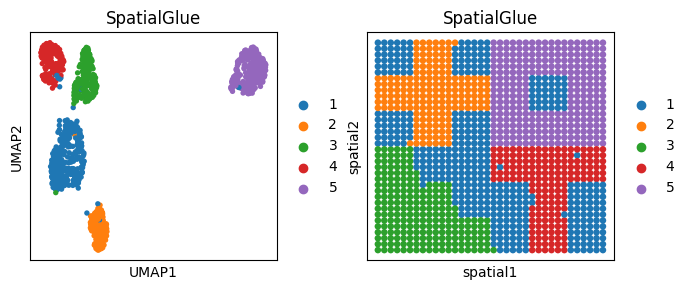

In [13]:
import matplotlib.pyplot as plt
fig, ax_list = plt.subplots(1, 2, figsize=(7, 3))
sc.pp.neighbors(adata, use_rep='SpatialGlue', n_neighbors=30)
sc.tl.umap(adata)

sc.pl.umap(adata, color='SpatialGlue', ax=ax_list[0], title='SpatialGlue', s=60, show=False)
sc.pl.embedding(adata, basis='spatial', color='SpatialGlue', ax=ax_list[1], title='SpatialGlue', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()